<h3>GOOGLE PLAY STORE REVIEW SENTIMENTAL ANALYSIS USING NLP ---> BY ISREAL UFUMAKA</h3>

In [684]:
#IMPORTING ALL NECESSARY LIBRARY TO BE USED IN THIS PROJECT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
import pickle
import re
import time
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [38]:
#IMPORTING THE GOOGLE PLAYSTORE DATASET, YOU CAN DOWNLOAD THIS DATASET DIRECTLY FROM KAGGLE
data=pd.read_csv("googleplaystore_user_reviews.csv",encoding="latin1")

In [39]:
data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


<B>Checking out your dataset for missing values and data types is very important
 so you dont run into errors or train a model that picks up noise from your dataset<B>

In [40]:
#CHECKING FOR MISSING VALUES
data.isnull().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [41]:
data.shape

(64295, 5)

In [42]:
data['App'].nunique()

1074

In [43]:
data.dropna(inplace=True)

In [44]:
data.isnull().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

In [45]:
data.shape

(37427, 5)

In [46]:
data.describe()

,Sentiment_Polarity,Sentiment_Subjectivity
count,37427.000000,37427.000000
mean,0.182171,0.492770
std,0.351318,0.259904
min,-1.000000,0.000000
25%,0.000000,0.357143
50%,0.150000,0.514286
75%,0.400000,0.650000
max,1.000000,1.000000


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37427 entries, 0 to 64230
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     37427 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37427 non-null  object 
 3   Sentiment_Polarity      37427 non-null  float64
 4   Sentiment_Subjectivity  37427 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.7+ MB


In [686]:
#CONCATINATING ONLY THE NEEDED COLUMNS TO BE USED BY THE MODEL LATER
df = pd.concat([data['Translated_Review'],data['Sentiment']],axis=1)
df

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive
...,...,...
64222,Most ads older many agents ..not much owner po...,Positive
64223,"If photos posted portal load, fit purpose. I'm...",Positive
64226,"Dumb app, I wanted post property rent give opt...",Negative
64227,I property business got link SMS happy perform...,Positive


In [538]:
data.shape

(37427, 5)

In [539]:
df['Sentiment'].value_counts()

Positive    23998
Negative     8271
Neutral      5158
Name: Sentiment, dtype: int64

In [687]:
#CHANGING THE TARGET COLUMNS TO NUMERICAL VALUES BETWEEN 0-3
df['Sentiment'] = [0 if i == 'Positive' else 1 if i == 'Negative' else 2 for i in df['Sentiment']]

In [688]:
df.head(10)

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,0
1,This help eating healthy exercise regular basis,0
3,Works great especially going grocery store,0
4,Best idea us,0
5,Best way,0
6,Amazing,0
8,"Looking forward app,",2
9,It helpful site ! It help foods get !,2
10,good you.,0
11,Useful information The amount spelling errors ...,0


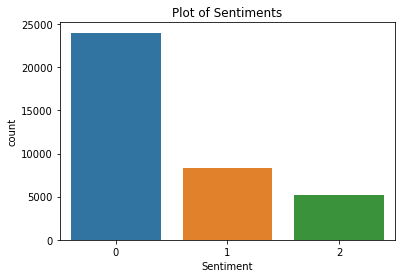

In [689]:
#VISUALIZING OUR TARGET VALUES
sns.countplot(df['Sentiment'])
plt.title("Plot of Sentiments")
plt.show()

In [690]:
df['Translated_Review'][1]

'This help eating healthy exercise regular basis'

In [691]:
class BadPatterns:
    
    def Patterns(self):
        '''
        This class contains popluarly used Regular Expressions 
        '''
        '''
        emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
            
        '''
        
        alpha_pattern = r'[^a-zA-Z]'
        
        patterns = {alpha_pattern:' '}
        
        return patterns
    
class Preprocessor:
    '''
    Class to a generic way of cleaning text for
    different NLP task. The process employed by
    this class are - remover of unwanted expresions
    like url, usernames (following the @ symbol),
    repetive words and numbers.
    
    This class also perfrom tokenization, and lemmatization. 
    '''
    def __init__(self):
        defualt_patterns = BadPatterns()
        
        self.patterns = defualt_patterns.Patterns()
        self.stop_words = set(stopwords.words('english'))
        
    def test(self):
        
        print(f'Patterns: {self.patterns} Stop words: {self.stop_words}')


    def text_cleaner(self,texts):
        start_time = time.time()
        sentence_list = []
        texts = texts
        
        
        #looping through the regular expressions to remove bad expressions from text
        for pattern, replacement in zip(self.patterns.keys(),self.patterns.values()):
            #Removing bad expressions
            for text in texts:

                cleaned_text = re.sub(pattern,replacement,text)
                sentence_list.append(cleaned_text)
                
            texts = sentence_list #perfroming a swap
            sentence_list = [] 
        #loops for perfroming lemmatization, and remover of stop words
        for text in texts:
            sentence = text.lower()
            sentence = sentence.split()
    
            sentence = [wordLemm.lemmatize(word) for word in sentence if word not in self.stop_words]
            sentence = ' '.join(sentence)
            sentence_list.append(sentence)
            sentence_list
            
        
        stop_time = time.time()
        execution_time = stop_time - start_time
        print(f'Cleaning Complete')
        print(f'Time Taken: {round(execution_time,3)} seconds')
        return sentence_list
             

In [692]:
#USING THE CLASS CREATED FOR CLEANING VALUES
p = Preprocessor()
cleaned_text = p.text_cleaner(df['Translated_Review'])
cleaned_text[0:2]

Cleaning Complete
Time Taken: 3.337 seconds


['like eat delicious food cooking food case best food help lot also best shelf life',
 'help eating healthy exercise regular basis']

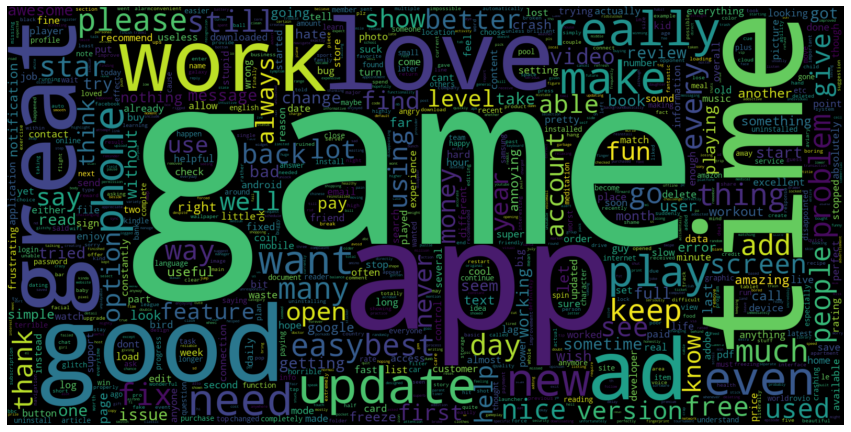

In [595]:
words = cleaned_text[:8000]
plt.figure(figsize = (15,15))
word_cloud  = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(words))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

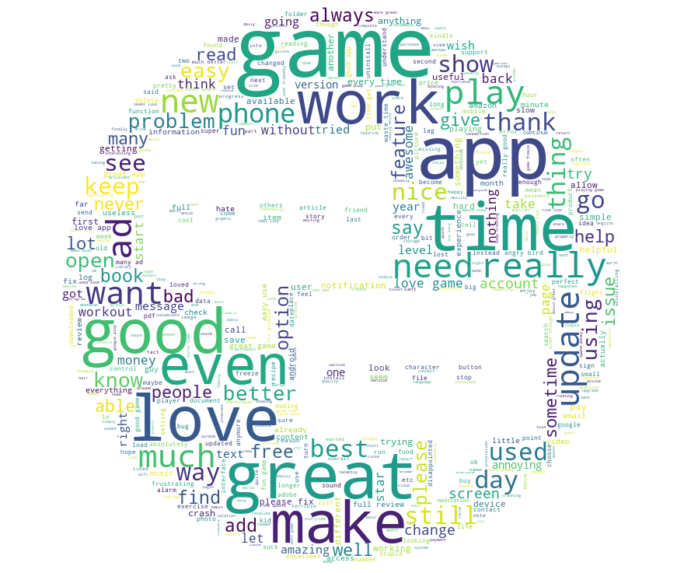

In [596]:
mask = np.array(Image.open('image3_edited.png'))
words = cleaned_text[:5000]
plt.figure(figsize = (12,12))
word_cloud  = WordCloud(mask = mask, width=mask.shape[1],height = mask.shape[0],
                        max_words = 500, background_color="white",random_state=42).generate(" ".join(words))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [693]:
#DEFINING OUR DEPENDED AND INDEPENDED VARIABLES
y = df['Sentiment'].values
X = cleaned_text

In [694]:
#USING THE TRAIN TEST SPLIT TO SPLIT DATA INTO 70% (TRAINING) AND 30% (TESTING)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42, shuffle=True)
print(f'X_train: {len(X_train)} X_test: {len(X_test)}')
print(f'Data Spliting Completed.')                                                 

X_train: 26198 X_test: 11229
Data Spliting Completed.


In [695]:
#CREATING A PIPELINE TO PROCESSING THE REVIEWS INTO O's AND 1's WITH Tf idf VECTORIZER
clf_LR = Pipeline([('tfidf',TfidfVectorizer()),
               ('clf',LogisticRegression())])

In [696]:
#TRAINING THE LOGISTIC MODEL
clf_LR.fit(X_train, y_train)
print(f'Fitting Model Completed.')

Fitting Model Completed.


C:\Users\USER\Anaconda3\envs\PythonCPU\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<B>MODEL EVALUATION IS VERY IMPORTANT, AS IT SHOWS YOU HOW WELL YOUR MODEL CAN BEHAVE WITH UNSEEN DATA</B>

In [697]:
#USING THE TEST DATA TO EVALUATED THE MODEL CREATED
Score = clf_LR.score(X_test,y_test)
print(f'Accuracy: {Score*100}')

Accuracy: 89.82990471101611


In [628]:
LR_pred = clf_LR.predict(X_test)

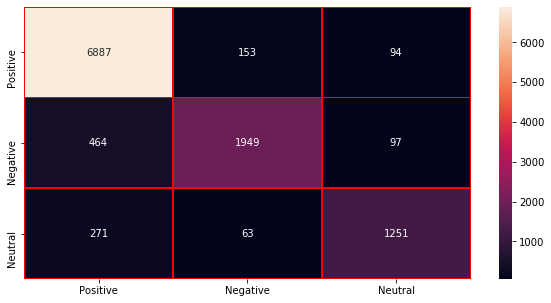

In [652]:
cm = confusion_matrix(y_test,LR_pred)
side_bar = ["Positive","Negative","Neutral"]

f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm,annot =True, linewidth=.5, linecolor="r", fmt=".0f", ax = ax)

ax.set_xticklabels(side_bar)
ax.set_yticklabels(side_bar)
plt.show()

In [653]:
report = classification_report(y_test,LR_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      7134
           1       0.90      0.78      0.83      2510
           2       0.87      0.79      0.83      1585

    accuracy                           0.90     11229
   macro avg       0.89      0.84      0.86     11229
weighted avg       0.90      0.90      0.90     11229



In [655]:
#SAVING THE TRAINED MODEL AS A PICKLE FILE TO DISK
filename = 'model.pickle'
pickle.dump(clf_LR, open(filename, 'wb'))

In [656]:
#LOADING  THE MODEL THAT WAS PREVIOUSLY SAVED
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)

In [698]:
def predict(texts,model):
    clean = Preprocessor()
    cleaned_text = clean.text_cleaner(texts)#Cleaning the text pased to the model
    
    sentiment = model.predict(texts)
        
    match = []
    for text, pred in zip(texts,sentiment):
        match.append((text,pred))#Saving the text and genetaed sentiments by the model
        
    df = pd.DataFrame(match,columns=['Reviews','Sentiments'])#Creating a dataframe to store predictions
    df = df.replace([0,1,2], ['Positive','Negative','Neutral'])
    
    return df

In [683]:
#USING THE SAVED MODEL FOR A REAL CASE
text = ['I should have never downloaded your app, its worthless',
            'what did you even build',
            'You killed it with this app',
       'Keep Up ALL THE GOOD WORK']

model.predict(text)

result = predict(text,model)
print(result)

Cleaning Complete
Time Taken: 0.0 seconds
                                             Reviews Sentiments
0  I should have never downloaded your app, its w...   Negative
1                            what did you even build    Neutral
2                        You killed it with this app   Positive
3                          Keep Up ALL THE GOOD WORK   Positive
